The RT60 is 83 ms
(6, 201674)
(257, 787, 6)


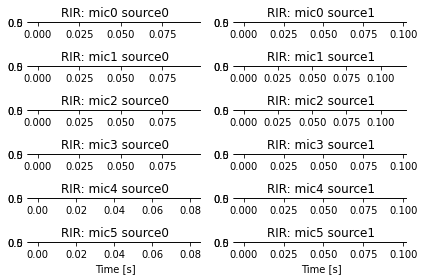

In [5]:
import numpy as np
import librosa
from scipy.fftpack import fft
from DistantSpeech.transform.transform import Transform
from DistantSpeech.beamformer.utils import pmesh, mesh, load_wav, save_audio, load_pcm
from DistantSpeech.beamformer.utils import load_audio as audioread
from DistantSpeech.beamformer.utils import save_audio as audiowrite
from DistantSpeech.beamformer.MicArray import MicArray, ArraySim
from DistantSpeech.beamformer.beamformer import beamformer
from DistantSpeech.beamformer.MicArray import MicArray, compute_tau
wavpath = '/home/wangwei/work/Beamforming-for-speech-enhancement-master/sample_data'
array_data, _ = load_wav(wavpath)

mic_angle_vector = [0,60,120,180,240,300]
sampling_frequency = 16000
fft_length = 512
fft_shift = 256
mic_diameter = 0.1
sound_speed = 343
look_direction = 30

signal = audioread("/home/wangwei/work/DistantSpeech/samples/audio_samples/cleanspeech_aishell3_2.wav")
noise = audioread("/home/wangwei/work/DistantSpeech/samples/noise/office1.wav")
fs = 16000
M = 6
mic_array = MicArray(arrayType="circular", r=mic_diameter/2, M=M)
mic_array_sim = mic_array.array_sim
# print(mic_array_sim.R)
array_data, premix = mic_array_sim.generate_audio(signal, interference=noise, source_angle=look_direction, interf_angle=270, sir=10, snr=30)
# audiowrite('mix.wav', np.transpose(array_data))
# audiowrite('signal.wav', np.transpose(premix[0, :, :]))
# audiowrite('interf.wav', np.transpose(premix[1, :, :]))
print(array_data.shape)
M = array_data.shape[0]
transform = Transform(n_fft=512, hop_length=256, channel=M)
D = transform.stft(np.transpose(array_data))
half_bin = D.shape[0]
frame_num = D.shape[1]
print(D.shape)

[1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j]
(257, 6, 6)
[[-1.26242770e-04]
 [-1.26242770e-04]
 [-2.02300114e-20]
 [ 1.26242770e-04]
 [ 1.26242770e-04]
 [-3.03450171e-20]]


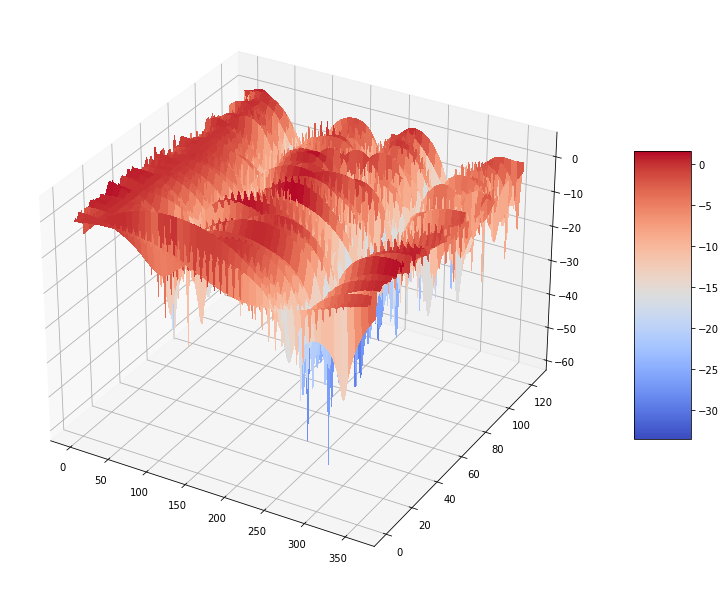

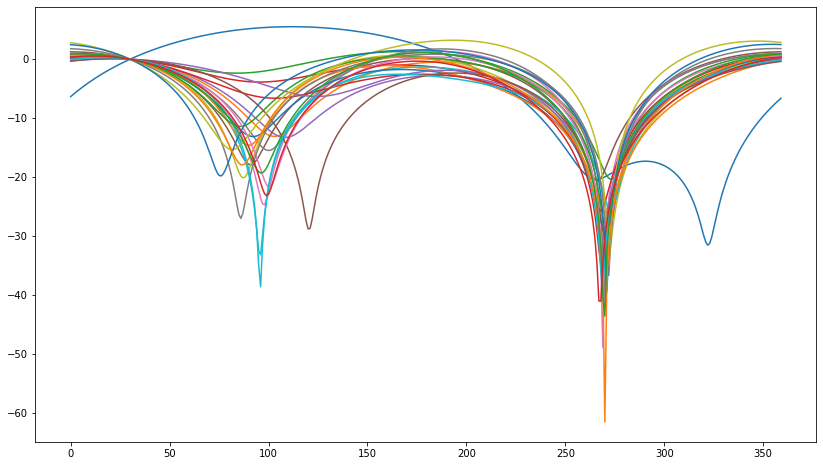

In [6]:
Rvv = np.zeros((M,M, half_bin), dtype=complex)
Ryy = np.zeros((M,M, half_bin), dtype=complex)
Rxx = np.zeros((M,M, half_bin), dtype=complex)
xi = np.zeros((frame_num, half_bin))
Rvv1 = np.zeros((frame_num, half_bin))
Yout = np.zeros((half_bin, frame_num), dtype=complex)



def normalize(steering_vector):
    for ii in range(0, fft_length):            
        weight = np.matmul(np.conjugate(steering_vector[:, ii]).T, steering_vector[:, ii])
        steering_vector[:, ii] = (steering_vector[:, ii] / weight) 
    return steering_vector   

def get_sterring_vector_mic(look_direction=0):
    freq_bin = np.linspace(0, half_bin - 1, half_bin)
    omega = 2 * np.pi * freq_bin * sampling_frequency / fft_length
    a = np.zeros((M, half_bin), dtype=complex)
    for k in range(half_bin):
        tau = compute_tau(mic_array=mic_array, incident_angle=np.array([look_direction, 0]) * np.pi / 180)
        a[:, k:k+1] = np.exp(-1j * omega[k] * tau)

    return a # [M, half_bin]

steer_vector = get_sterring_vector_mic(look_direction=look_direction)  # [M, freq]
print(steer_vector[:,0])


init_frame = 10
for n  in range(init_frame):
    y = D[:, n, :] # [freq, channel]
    psd_yy = np.einsum('ij,il->ijl', y, y.conj()) # [freq, M,M]
    if n == 0:
        print(psd_yy.shape)
    Rvv = Rvv + np.transpose(psd_yy, (1, 2, 0))

Rvv = Rvv/init_frame

w = np.zeros((M,half_bin),dtype=complex)
for k in range(half_bin):
    Rvv_inv = np.linalg.inv(Rvv[:, :, k])
    w[:, k:k+1] = Rvv_inv @ steer_vector[:, k:k+1]/(steer_vector[:, k:k+1].conj().T@Rvv_inv@steer_vector[:, k:k+1])

beamformer_obj = beamformer(mic=mic_array, frame_len=512)
beamout = beamformer_obj.compute_beampattern(mic_array, weights=w)
tau = compute_tau(mic_array, np.array([30 * np.pi / 180, 0]))
print(tau)
mesh(beamout[:, 2:-2].T)

import matplotlib.pyplot as plt
plt.figure(figsize=(14, 8))
plt.plot(beamout[:, 8:32])
# plt.plot(beamout[:, 30:33])

u = np.zeros((M,1))
u[0,0] = 1
alpha_yy = 0.85
for n in range(frame_num):
    y = D[:, n, :] # [F,M]
    # psd_yy = np.einsum('ij,il->ijl', y, y.conj())
    # Ryy = alpha_yy * Ryy + (1 - alpha_yy) * (np.transpose(psd_yy, (1, 2, 0)))
    for k in range(half_bin):
        # Rvv_inv = np.linalg.inv(Rvv[:, :, k])
        # xi[n, k] = np.real(np.trace(Rvv_inv @ Ryy[:, :, k])) - M
        # if xi[n, k] < 0:
        #     xi[n, k] = 1e-3
        # Rvv1[n, k] = np.real(Rvv[0, 0, k])
        # w[:, k:k+1] = (Rvv_inv @ Ryy[:, :, k] - np.eye(M))@u/(np.trace(Rvv_inv @ Ryy[:, :, k]) -M)
        Yout[k, n] = w[:, k:k+1].conj().T@y[k, :].T

yout = transform.istft(Yout)
# audiowrite('audio.wav', yout)